First of all the standard packages will be installed and we check which version of the CLMM code is currently installed

In [1]:
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import matplotlib.pyplot as plt
import numpy as np
import astropy
from astropy import units
import clmm.dataops as da
import clmm.galaxycluster as gc
import clmm.theory as theory
from clmm import Cosmology
from clmm import support
from clmm.support import mock_data as mock
from clmm.support import sampler
from clmm.support.sampler import *
from clmm.support.sampler import fitters
import random
from scipy.interpolate import interp1d

plt.rcParams['font.family']=['gothambook','gotham','gotham-book','serif']

clmm.__version__


/Users/nicomasii/opt/anaconda3/lib/python3.8/site-packages/clmm-1.0.5-py3.8.egg/clmm/theory/__init__.py:38: UserWarning: CLMM Backend requested `ccl' is not available, trying others...
/Users/nicomasii/opt/anaconda3/lib/python3.8/site-packages/clmm-1.0.5-py3.8.egg/clmm/theory/__init__.py:48: UserWarning: * NumCosmo BACKEND also not available
/Users/nicomasii/opt/anaconda3/lib/python3.8/site-packages/clmm-1.0.5-py3.8.egg/clmm/theory/__init__.py:45: UserWarning: * USING cluster_toolkit+astropy BACKEND


'1.0.5'

Since we are working with the random modul we use random seed in the next step for reproducibility.


In [2]:
np.random.seed(22)

To create mock data, we need to define a true cosmology, which is currently done with astropy's cosmology library.

In [3]:
cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)


We now set some parameters for a mock galaxy cluster:
    cluster_data[k][0] = cluster_m
    cluster_data[k][1] = concentration
    cluster_data[k][2] = cluster_ra
    cluster_data[k][3] = cluster_dec
    cluster_data[k][4] = cluster_z
    cluster_data[k][5] = ngals
    cluster_data[k][6] = logm
    cluster_data[k][7] = number density 
and print the array

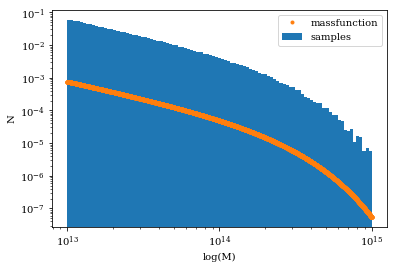

[3.15288075e+13 1.33415588e+13 1.81341290e+13 ... 1.11044687e+13
 1.51481143e+13 8.47965710e+13]


In [9]:
lower_limit =13
upper_limit =15
nbinhist=100
norm = (upper_limit-lower_limit)/nbinhist

M_star = 2.e14
b=4*10**(-5)
numsamp= 10**6
numstep = 10**4

#define x range 1e12-1e15 in num steps
x = np.logspace(lower_limit,upper_limit,numstep)
#define y values from the function 
y = (b*(1/(x/M_star))*np.exp(-(x)/M_star))

#calculate cumulative sum of the y values (numpy)
y_cm = np.cumsum(y)
y_cm = y_cm-min(y_cm)
y_cm = y_cm/np.max(y_cm)

#invert x and y variables (flipping)and interpolate that function 
f = interp1d(y_cm,x , fill_value=(0,1))
#Generate N random numbers uniformly between 0 & 1: u_i~U(0,1)
ynew = np.random.random(numsamp)
#Using the Inverse of the CDF and the values u_i, compute x_i = F^-1(u_i)
x_samp = f(ynew) 

#plot it to see the result
plt.hist(x_samp, bins=np.logspace(lower_limit,upper_limit,nbinhist),weights=np.repeat(numsamp/sum(y*x),numsamp)/norm,label='samples')
plt.yscale('log')
plt.xscale('log')
plt.plot(x, y, '.',label='massfunction')
plt.xlabel('log(M)')
plt.ylabel('N')
plt.legend()
plt.show()

print(x_samp)

#use that interpolated function to predict num samples



In [10]:
np.set_printoptions(precision=3)   
num = 10
cluster_data = np.zeros((num,7))
#m_star=1.8.e14
for k in range(num):
   #cluster_data[k][7] = np.random.randint(1.e(-8),1.e(-2))    
    cluster_data[k][0] = x_samp[k] #masse
    cluster_data[k][6] = np.log(cluster_data[k][0])/np.log(10)
    cluster_data[k][2] = 0
    cluster_data[k][3] = 0
    cluster_data[k][4] = np.random.uniform(0.1,0.6)
    cluster_data[k][1] = 5.72/((1+cluster_data[k][4])**0.71)*(cluster_data[k][0]/10.e14)**(-0.081)
    cluster_data[k][5] = np.random.randint(50,10000)
    print(cluster_data[k][0])
    
     
#print(cluster_data)
print(cluster_data[k][0])

31528807471533.21
13341558778797.023
18134129014534.47
43311571151855.305
57494243472142.664
25109615886994.3
27569500450545.688
19950218520070.234
16568380902613.531
10166883725293.494
10166883725293.494


In [ ]:
'''
import numpy as np
import scipy.interpolate as interpolate

def inverse_transform_sampling(data, n_bins=40, n_samples=1000):
    hist, bin_edges = np.histogram(data, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    r = np.random.rand(n_samples)
    return inv_cdf(r)
'''

In [ ]:
'''
#input mass
#print(cluster_data[:,0])
plt.hist(cluster_data[:,0], 50, density=1, facecolor='g', alpha=0.75)
#plt.plot(cluster_data[:,0] ,  , "ob")
plt.xlabel('M_input')
plt.ylabel('N')
plt.show()
'''

In [ ]:

ideal_data = []
noisy_data = []

for k in range(num):
    buggy_data = mock.generate_galaxy_catalog(cluster_data[k][0], 
                                              cluster_data[k][4], 
                                              cluster_data[k][1], 
                                                           cosmo, 
                                                       'chang13', 
                             zsrc_min = cluster_data[k][4] + 0.1,
                                                 shapenoise=0.05, 
                                      photoz_sigma_unscaled=0.05, 
                                    ngals=int(cluster_data[k][5])) 
    
    #sortiert nachher die galaxien raus die den falschen redshift besitzen
    mask = buggy_data['z'] < cluster_data[k][4] 
    #die galaxien sollten entfernt werden nicht maskiert...nur vorrübergehend
   
    buggy_data['z'] = np.where(buggy_data['z'] < cluster_data[k][4], 
                               np.random.uniform(cluster_data[k][4],
                                            cluster_data[k][4]+0.1), 
                                                    buggy_data['z'])
    
    mask = buggy_data['z'] < cluster_data[k][4]
    realredshift = buggy_data['z']
    #print(sum(buggy_data['z']<=cluster_data[k][4]))

    ideal_data.append(mock.generate_galaxy_catalog(cluster_data[k][0],
                                                   cluster_data[k][4], 
                                                   cluster_data[k][1],
                                                                cosmo,
                                                            'chang13',
                                  zsrc_min = cluster_data[k][4] + 0.1, 
                                     ngals = int(cluster_data[k][5]))) 
    noisy_data.append(buggy_data)


    

Now we plot the redshifts to see of we have any redshifts under the cluster redshift

In [ ]:
'''
for k in range(num):
    plt.figure(figsize=(7,5))
    plt.hist(ideal_data[k]['z'], density = True, alpha=0.5, bins = 50, label='ideal data')
    plt.hist(noisy_data[k]['z'], alpha=0.5, density = True, bins = 50, label='noisy data')
    plt.axvline(x = cluster_data[k][4], color='orange', label = 'cluster redshift')
    plt.xlabel(r'$z_{src}$', fontsize = 20)
    plt.ylabel(r'$N(z$)', fontsize = 20)
    plt.legend()
    plt.xlim(0,5)
    plt.show()
'''

Now we compete the radius which we will need later on

In [ ]:
radius = []
for k in range(num):
    variable = clmm.dataops._compute_lensing_angles_astropy(cluster_data[k][2], 
                                                            cluster_data[k][3], 
                                                            ideal_data[k]['ra'], 
                                                            ideal_data[k]['dec'])
    radius.append(variable)

The galaxy catalogs are converted to a clmm.GalaxyCluster object and may be saved for later use.


In [ ]:
gc_object =[]

for k in range(num):

    cluster_id = "CL_ideal"
    gc_object.append( clmm.GalaxyCluster(cluster_id, 
                                 cluster_data[k][2],
                                 cluster_data[k][3],
                                 cluster_data[k][4], 
                                     ideal_data[k]))
    gc_object[k].save('ideal_GC_'+str(k)+'.pkl')

gc_object =[]

for k in range(num):

    cluster_id = "CL_noisy"
    gc_object.append( clmm.GalaxyCluster(cluster_id,
                                 cluster_data[k][2],
                                 cluster_data[k][3],
                                 cluster_data[k][4], 
                                     noisy_data[k]))
    gc_object[k].save('noisy_GC_'+str(k)+'.pkl')


Any saved clmm.GalaxyCluster object may be read in for analysis.

In [ ]:
cl_ideal = []
cl_noisy = []
for k in range(num):
    cl_ideal.append (clmm.GalaxyCluster.load('ideal_GC_'+str(k)+'.pkl'))
    cl_noisy.append (clmm.GalaxyCluster.load('noisy_GC_'+str(k)+'.pkl'))

Redshift of galaxies generated by mock data are distributed following the Chang. (2013) redshift distribution.

In [ ]:
'''
for k in range(num):
    plt.figure(figsize=(7,5))
    plt.hist(cl_ideal[k].galcat['z'], density = True, bins = 50)
    plt.axvline(x = cluster_data[k][4], color='orange', label = 'cluster redshift')
    plt.xlabel(r'$z_{src}$', fontsize = 20)
    plt.ylabel(r'$N(z$)', fontsize = 20)
    plt.legend()
    plt.xlim(0,5)
'''

Deriving observables

Computing shear

clmm.GalaxyCluster.compute_tangential_and_cross_components calculates the tangential and cross shears for each source galaxy in the cluster.

In [ ]:
for k in range(num):
    cl_ideal[k].compute_tangential_and_cross_components(geometry="flat")
    cl_noisy[k].compute_tangential_and_cross_components(geometry="flat")
pass

Radially binning the data

In [ ]:
bin_edges = da.make_bins(0.2, 4, 15, method='evenwidth')

In [ ]:
for k in range(num):

    a = cl_ideal[k].make_radial_profile("Mpc",
                      include_empty_bins=True, 
                               bins=bin_edges, 
                                  cosmo=cosmo, 
                         gal_ids_in_bins=True,)#return_binnumber=True does not work
    
    b = cl_noisy[k].make_radial_profile("Mpc",
                      include_empty_bins=True, 
                               bins=bin_edges,
                                  cosmo=cosmo, 
                         gal_ids_in_bins=True,)
    #masking
    maski = cl_ideal[k].profile['z'] > cluster_data[k][4]
    maskn = cl_noisy[k].profile['z'] > cluster_data[k][4]
    mask= maski*maskn
    cl_ideal[k].profile =  cl_ideal[k].profile[mask]
    cl_noisy[k].profile =  cl_noisy[k].profile[mask]


pass


In [ ]:
print(cl_ideal[k].profile['gt_err'])

After this, the object acquires the clmm.GalaxyCluster.profile attribute.

#Create the reduced tangential shear models
We consider two options:

First, the naive and wrong approach: the reduced tangential shear in a given radial bin 𝑗 is given by 𝑔𝑡(𝜃𝑗,⟨𝑧𝑠⟩), where ⟨𝑧𝑠⟩ is the average redshift in the bin. In that case, the corresponding model is simply given by the fucntion below:


In [ ]:
def model_reduced_tangential_shear_zdistrib(radius, 
                                              logm,
                                              data,
                                           catalog,
                                           profile, 
                                         cluster_z,
                                    concentration): 
    m = 10**logm
    gt_model = []
    for i in range(len(radius)):
        
        r = profile['radius'][i]
        galist = profile['gal_id'][i]
        
        z_list = catalog.galcat['z'][galist]
        shear = clmm.compute_reduced_tangential_shear(r,
                                                      m,
                                          concentration,
                                              cluster_z,
                                                 z_list, 
                                                  cosmo, 
                                         delta_mdef=200, 
                               halo_profile_model='nfw')
        if len(galist) == 0:
            gt_model.append(1e-16)
            print("this is bad")
        else:
            gt_model.append(np.mean(shear))

    return gt_model

In [ ]:
def model_reduced_tangential_shear_singlez(r,
                                        logm,
                                       z_src,
                                   cluster_z,
                              concentration):
    m = 10.**logm
    gt_model = clmm.compute_reduced_tangential_shear(r,
                                                     m,
                                         concentration,
                                             cluster_z,
                                                 z_src,
                                                 cosmo,
                                        delta_mdef=200,
                              halo_profile_model='nfw')    
    return gt_model

Before fitting, let's first vizualise these models using the known true mass

In [ ]:
gt_model_ideal_singlez = []
gt_model_ideal_zdistrib = []
gt_model_noisy_singlez = []
gt_model_noisy_zdistrib = []
r=[]
for k in range(num):
    r.append(cl_ideal[k].profile['radius'])

    gt_model_ideal_singlez.append(model_reduced_tangential_shear_singlez(r[k], 
                                                           cluster_data[k][6],
                                                     cl_ideal[k].profile['z'],
                                                           cluster_data[k][4], 
                                                          cluster_data[k][1]))
    
    gt_model_ideal_zdistrib.append(model_reduced_tangential_shear_zdistrib(r[k],
                                                             cluster_data[k][6],
                                                                  ideal_data[k],
                                                                    cl_ideal[k], 
                                                            cl_ideal[k].profile,
                                                             cluster_data[k][4], 
                                                            cluster_data[k][1]))
    
    gt_model_noisy_singlez.append(model_reduced_tangential_shear_singlez(r[k],
                                                           cluster_data[k][6],
                                                     cl_noisy[k].profile['z'],
                                                           cluster_data[k][4], 
                                                          cluster_data[k][1]))
    
    gt_model_noisy_zdistrib.append(model_reduced_tangential_shear_zdistrib(r[k],
                                                             cluster_data[k][6],
                                                                  noisy_data[k], 
                                                                    cl_noisy[k], 
                                                            cl_noisy[k].profile,
                                                             cluster_data[k][4], 
                                                            cluster_data[k][1]))
    

In [ ]:

for k in range (num):
    print(k)
    plt.figure(figsize=(20,8))

    plt.subplot(1,2,1)

    plt.title('ideal data', fontsize=20)
    plt.errorbar(r[k],
                 cl_ideal[k].profile['gt'],
                 cl_ideal[k].profile['gt_err'],
                 c='k',linestyle='', 
                 marker='o',
                 label=r'ideal data, $M_{input}$ = %.2e Msun' % cluster_data[k][0])
    plt.loglog(r[k],gt_model_ideal_zdistrib[k],'b', 
               label=r'model w/ zdistrib, $M_{input}$ = %.2e Msun' % cluster_data[k][0])
    plt.loglog(r[k],gt_model_ideal_singlez[k],'-y', 
               label=r'model w/o zdistrib, $M_{input}$ = %.2e Msun' % cluster_data[k][0])
    plt.xlabel('r [Mpc]', fontsize = 20)
    plt.ylabel(r'$g_t$', fontsize = 20)
    plt.xlim(min(cl_ideal[k].profile['radius']), max(cl_ideal[k].profile['radius']))
    plt.legend(fontsize = 15)

    plt.subplot(1,2,2)

    plt.title('noisy data', fontsize=20)
    plt.errorbar(r[k],
                 cl_noisy[k].profile['gt'],
                 cl_noisy[k].profile['gt_err'],
                 c='k',
                 linestyle='', 
                 marker='o',
                 label=r'noisy data, $M_{input}$ = %.2e Msun' % cluster_data[k][0])
    plt.loglog(r[k],
               gt_model_noisy_zdistrib[k],
               '-b', 
               label=r'model w/ zdistrib, $M_{input}$ = %.2e Msun' % cluster_data[k][0])
    plt.loglog(r[k],
               gt_model_noisy_singlez[k],
               '-y',
               label=r'model w/o zdistrib, $M_{input}$ = %.2e Msun' % cluster_data[k][0])
    plt.xlabel('r [Mpc]', fontsize = 20)
    plt.ylabel(r'$g_t$', fontsize = 20)
    plt.xlim(min(cl_noisy[k].profile['radius']), max(cl_noisy[k].profile['radius']))
    plt.ylim(min(gt_model_ideal_zdistrib[k]),max(gt_model_ideal_zdistrib[k]))
    plt.legend(fontsize = 15)


The naive model that uses the average redshift in the bin clearly does not give the right description of the ideal data (left panel), and will yield biased mass results if used for fitting (see below). For ideal data, the model that accounts for the redshift distribution is, by construction, an excellent description of the data (solid blue line). The same is true for noisy data (right panel), although the noise make the naive model appear "less biased".


Mass fitting
We estimate the best-fit mass using scipy.optimize.curve_fit. We compare estimated mass for noisy and ideal data, using both models described above (naive with average redshift or the model taking into account the redshift distribution). The choice of fitting log10𝑀 instead of 𝑀 lowers the range of pre-defined fitting bounds from several order of magnitude for the mass to unity. From the associated error Δ(log10𝑀) we calculate the error to mass as Δ𝑀=𝑀𝑓𝑖𝑡log(10)Δ(log10𝑀).

In [ ]:
m_est_ideal_zdistrib = [None]*num
m_est_err_ideal_zdistrib = [None]*num
for k in range(num):

    func = lambda r, x : model_reduced_tangential_shear_zdistrib(r,x, 
                                                       ideal_data[k],
                                                         cl_ideal[k], 
                                                 cl_ideal[k].profile, 
                                                  cluster_data[k][4], 
                                                  cluster_data[k][1])
    popt,pcov = fitters['curve_fit'](func, 
                        cl_ideal[k].profile['radius'], 
                        cl_ideal[k].profile['gt'], 
                        cl_ideal[k].profile['gt_err'], bounds=[10.,16.], p0=14.6)

    m_est_ideal_zdistrib[k] = 10.**popt[0]
    m_est_err_ideal_zdistrib[k] =  m_est_ideal_zdistrib[k] * np.sqrt(pcov[0][0]) * np.log(10) 
print(popt[0])
print(pcov[0][0])
print(np.sqrt(pcov[0][0]))
print(np.log(10))
print(m_est_err_ideal_zdistrib)
print(m_est_ideal_zdistrib)

In [ ]:
m_est_ideal_singlez = [None]*num
m_est_err_ideal_singlez = [None]*num
for k in range(num):

    funct = lambda r, logm : model_reduced_tangential_shear_singlez(r,
                                                                 logm, 
                                             cl_ideal[k].profile['z'], 
                                                   cluster_data[k][4], 
                                                   cluster_data[k][1])
    popt,pcov = fitters['curve_fit'](funct, 
                        cl_ideal[k].profile['radius'], 
                        cl_ideal[k].profile['gt'], 
                        cl_ideal[k].profile['gt_err'], bounds=[10.,17.])

    m_est_ideal_singlez[k] = 10.**popt[0]
    m_est_err_ideal_singlez[k] = m_est_ideal_singlez[k] * np.sqrt(pcov[0][0]) * np.log(10)



In [ ]:
m_est_noisy_zdistrib = [None]*num
m_est_err_noisy_zdistrib = [None]*num
for k in range(num):
    cluster_z = cluster_data[k][4]
    concentration = cluster_data[k][1]
    #logm = cluster_data[k][6]
    funct = lambda r, logm : model_reduced_tangential_shear_zdistrib(r, 
                                                                  logm, 
                                                         noisy_data[k],
                                                           cl_noisy[k], 
                                                   cl_noisy[k].profile, 
                                                    cluster_data[k][4], 
                                                    cluster_data[k][1]) 
    popt,pcov = fitters['curve_fit'](funct, 
                        cl_noisy[k].profile['radius'], 
                        cl_noisy[k].profile['gt'], 
                        cl_noisy[k].profile['gt_err'], bounds=[10.,16.])

    m_est_noisy_zdistrib[k] = 10.**popt[0]
    m_est_err_noisy_zdistrib[k] =  m_est_noisy_zdistrib[k] * np.sqrt(pcov[0][0]) * np.log(10) 



In [ ]:
m_est_noisy_singlez = [None]*num
m_est_err_noisy_singlez =[None]*num
for k in range(num):

    funct = lambda r, logm : model_reduced_tangential_shear_singlez(r, 
                                                                 logm, 
                                             cl_noisy[k].profile['z'],
                                                   cluster_data[k][4], 
                                                   cluster_data[k][1])
    popt,pcov = fitters['curve_fit'](funct, 
                        cl_noisy[k].profile['radius'], 
                        cl_noisy[k].profile['gt'], 
                        cl_noisy[k].profile['gt_err'],bounds=[10.,16.])

    m_est_noisy_singlez[k] = 10.**popt[0]
    m_est_err_noisy_singlez[k] =  m_est_noisy_singlez[k] * np.sqrt(pcov[0][0]) * np.log(10) 


In [ ]:

for k in range(num):
    print(k)
    print(f'Cluster {k}')
    
    print(f'The input mass = {cluster_data[k][0]:.2e} Msun\n')

    print("Without accounting for the redshift distribution in the model\n")
    print(f'Best fit mass for ideal data = {m_est_ideal_singlez[k]:.2e} +/- {m_est_err_ideal_singlez[k]:.2e} Msun')
    print(f'Best fit mass for noisy data = {m_est_noisy_singlez[k]:.2e} +/- {m_est_err_noisy_singlez[k]:.2e} Msun\n')

    print("Accounting for the redshift distribution in the model\n")
    print(f'Best fit mass for ideal data = {m_est_ideal_zdistrib[k]:.2e} +/- {m_est_err_ideal_zdistrib[k]:.2e} Msun')


As expected, the reconstructed mass is biased when the redshift distribution is not accounted for in the model

Visualization of the results
For visualization purpose, we calculate the reduced tangential shear predicted by the model with estimated masses for noisy and ideal data.

In [ ]:
gt_est_ideal_zdistrib = []
gt_est_noisy_zdistrib = []
gt_est_ideal_singlez = []
gt_est_noisy_singlez = []

for k in range(num):

    gt_est_ideal_zdistrib.append(model_reduced_tangential_shear_zdistrib
                                                                     (r[k],
                                np.log(m_est_ideal_zdistrib[k])/np.log(10), 
                                                             ideal_data[k], 
                                                               cl_ideal[k], 
                                                       cl_ideal[k].profile, 
                                                        cluster_data[k][4], 
                                                       cluster_data[k][1]))

    gt_est_noisy_zdistrib.append(model_reduced_tangential_shear_zdistrib
                                                                     (r[k], 
                                np.log(m_est_noisy_zdistrib[k])/np.log(10), 
                                                             noisy_data[k], 
                                                               cl_noisy[k], 
                                                       cl_noisy[k].profile,
                                                        cluster_data[k][4], 
                                                       cluster_data[k][1]))

    gt_est_ideal_singlez.append(model_reduced_tangential_shear_singlez
                                                                    (r[k], 
                                np.log(m_est_ideal_singlez[k])/np.log(10),
                                                 cl_ideal[k].profile['z'],
                                                       cluster_data[k][4], 
                                                      cluster_data[k][1]))
    
    gt_est_noisy_singlez.append(model_reduced_tangential_shear_singlez
                                                                    (r[k],
                                np.log(m_est_noisy_singlez[k])/np.log(10),
                                                 cl_noisy[k].profile['z'],
                                                       cluster_data[k][4],
                                                      cluster_data[k][1]))


We compare to tangential shear obtained with theoretical mass. We plot the reduced tangential shear models first when redshift distribution is accounted for in the model then for the naive approach, with respective best-fit masses.

In [ ]:

for k in range(num):

    plt.figure(figsize=( 20 , 6 ))
    plt.subplot( 1 , 2 , 1 )
    plt.title(r'tangential shear $g_t$ (ideal data)', fontsize=20)
    plt.errorbar(r[k],
                 cl_ideal[k].profile['gt'],
                 cl_ideal[k].profile['gt_err'],
                 c='k',
                 linestyle='', 
                 marker='o', 
                 label=r'ideal data, $M_{input}$ = %.1e Msun' % cluster_data[k][0])
    plt.loglog(r[k],gt_est_ideal_zdistrib[k],'-b', 
           label=fr'model w/ zdistrib, M_fit = {m_est_ideal_zdistrib[k]:.2e} $\pm$ {m_est_err_ideal_zdistrib[k]:.2e} Msun')
    plt.loglog(r[k],gt_est_ideal_singlez[k],'-y',\
           label=fr'model w/o zdistrib, M_fit = {m_est_ideal_singlez[k]:.2e} $\pm$ {m_est_err_ideal_singlez[k]:.2e} Msun')

    plt.xlabel('r [Mpc]', fontsize = 20)
    plt.ylabel(r'$g_t$', fontsize = 20)
    plt.xlim(min(cl_ideal[k].profile['radius']), max(cl_ideal[k].profile['radius']))
    plt.legend(fontsize = 15)


    plt.subplot( 1 , 2 , 2 )
    plt.title(r'tangential shear $g_t$ (noisy data)', fontsize=20)
    plt.errorbar(r[k],cl_noisy[k].profile['gt'],cl_noisy[k].profile['gt_err'],c='k',linestyle='', marker='o', label=r'noisy data, $M_{input}$ = %.1e Msun' % cluster_data[k][0])
    #plt.loglog(r,gt_model_noisy,'-r',  label='model, $M_{input}$ = %.3e Msun' % cluster_data[k][0])
    plt.loglog(r[k],gt_est_noisy_zdistrib[k],'-b', 
           label=fr'model w/ zdistrib, M_fit = {m_est_noisy_zdistrib[k]:.2e} $\pm$ {m_est_err_noisy_zdistrib[k]:.2e} Msun')
    plt.loglog(r[k],gt_est_noisy_singlez[k],'-y', 
           label=fr'model w/o zdistrib, M_fit = {m_est_noisy_singlez[k]:.2e} $\pm$ {m_est_err_noisy_singlez[k]:.2e} Msun')

    plt.xlabel('r [Mpc]', fontsize = 20)
    plt.ylabel(r'$g_t$', fontsize = 20)
    plt.xlim(min(cl_noisy[k].profile['radius']), max(cl_noisy[k].profile['radius']))
    plt.legend(fontsize = 15)
    
    


In [ ]:
#calculate the average of the input masses
cluster_data_mass_avg = np.average(cluster_data[:,0])
#calculate the avere of the estimated mass (ideal data) (bad method)
m_est_ideal_singlez_avg = np.average(m_est_ideal_singlez)
#calculate the standarddeviation of the estimated mass (ideal data) (bad method)
m_est_ideal_singlez_avg_err = np.sum(m_est_err_ideal_singlez)/np.size(m_est_err_ideal_singlez)


#calculate the avere of the estimated mass (noisy data) (bad method)
m_est_noisy_singlez_avg = np.average(m_est_noisy_singlez)
#calculate the standarddeviation of the estimated mass (noisy data) (bad method)
m_est_noisy_singlez_avg_err = np.sum(m_est_err_noisy_singlez)/np.size(m_est_err_noisy_singlez)




#calculate the avere of the estimated mass (ideal data)(good method)
m_est_ideal_zdistrib_avg = np.average(m_est_ideal_zdistrib)
#calculate the standarddeviation of the estimated mass (ideal data)(good method)
m_est_ideal_zdistrib_avg_err = np.sum(m_est_err_ideal_zdistrib)/np.size(m_est_err_ideal_zdistrib)


#calculate the avere of the estimated mass (noisy data)(good method)
m_est_noisy_zdistrib_avg = np.average(m_est_noisy_zdistrib)
#calculate the standarddeviation of the estimated mass (noisy data)(good method)
m_est_noisy_zdistrib_avg_err = np.sum(m_est_err_noisy_zdistrib)/np.size(m_est_err_noisy_zdistrib)

#print the averages:
print(cluster_data_mass_avg)
print(m_est_ideal_singlez_avg)
print(m_est_ideal_singlez_avg_err)
print(m_est_noisy_singlez_avg)
print(m_est_ideal_zdistrib_avg)
print(m_est_noisy_zdistrib_avg)


In [ ]:
#input estimated masszdistrib
plt.hist(m_est_ideal_singlez, 50,  facecolor='y', alpha=0.5, label="estimated mass ideal")
plt.hist(m_est_noisy_singlez, 50,  facecolor='b', alpha=0.5, label="estimated mass noisy")
plt.axvline(cluster_data_mass_avg, color='k', linestyle='solid', linewidth=1 , label="input mass average")
plt.axvline(m_est_ideal_singlez_avg, color='c', linestyle='solid', linewidth=1, label="estimated mass avg noisy")
plt.axvline(m_est_ideal_singlez_avg-m_est_ideal_singlez_avg_err, color='c', linestyle='dashed', linewidth=1, label="estimated mass avg err noisy")
plt.axvline(m_est_ideal_singlez_avg+m_est_ideal_singlez_avg_err, color='c', linestyle='dashed', linewidth=1)
plt.axvline(m_est_noisy_singlez_avg, color='r', linestyle='solid', linewidth=1, label="estimated mass avg ideal")
plt.axvline(m_est_noisy_singlez_avg-m_est_noisy_singlez_avg_err, color='r', linestyle='dashed', linewidth=1, label="estimated mass avg err ideal")
plt.axvline(m_est_noisy_singlez_avg+m_est_noisy_singlez_avg_err, color='r', linestyle='dashed', linewidth=1)
plt.hist(cluster_data[:,0], 50, facecolor='g', alpha=0.5 , label="input")
#plt.errorbar(m_est_ideal_singlez_avg,0, xerr=m_est_ideal_singlez_avg_err, fmt="", color="r")
plt.xlabel('Estimated mass vs input mass bad method')
plt.legend(loc="upper left")
plt.ylabel('N')
plt.show()

In [ ]:
#input estimated masszdistrib
plt.hist(m_est_ideal_zdistrib, 50,  facecolor='y', alpha=0.5, label="estimated mass ideal")
plt.hist(m_est_noisy_zdistrib, 50,  facecolor='b', alpha=0.5, label="estimated mass noisy")
plt.axvline(cluster_data_mass_avg, color='k', linestyle='solid', linewidth=1 , label="input mass average")
plt.axvline(m_est_ideal_zdistrib_avg, color='c',alpha=0.5, linestyle='solid', linewidth=1, label="estimated mass avg noisy")
plt.axvline(m_est_ideal_zdistrib_avg-m_est_ideal_zdistrib_avg_err, color='c', linestyle='dashed', linewidth=1, label="estimated mass avg err noisy")
plt.axvline(m_est_ideal_zdistrib_avg+m_est_ideal_zdistrib_avg_err, color='c', linestyle='dashed', linewidth=1)
plt.axvline(m_est_noisy_zdistrib_avg, color='r', linestyle='solid', linewidth=1, label="estimated mass avg ideal")
plt.axvline(m_est_noisy_zdistrib_avg-m_est_noisy_zdistrib_avg_err, color='r', linestyle='dashed', linewidth=1, label="estimated mass avg err ideal")
plt.axvline(m_est_noisy_zdistrib_avg+m_est_noisy_zdistrib_avg_err, color='r', linestyle='dashed', linewidth=1)
plt.hist(cluster_data[:,0], 50, facecolor='g', alpha=0.5 , label="input")
#plt.errorbar(m_est_ideal_singlez_avg,0, xerr=m_est_ideal_singlez_avg_err, fmt="", color="r")
plt.xlabel('Estimated mass vs input mass good method')
plt.legend(loc="upper left")
plt.ylabel('N')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
from math import log, exp
mean = np.log(m_est_noisy_singlez)/np.log(10)


std = m_est_err_noisy_singlez
print(mean)
print(std)
x_min=-100
x_max=100
x = np.linspace(x_min, x_max, 1000)
for k in range(num):


    y = scipy.stats.norm.pdf(x,mean[k],std[k])

#plt.plot(x,y, color='coral')



   

    plt.plot(x,y, color='coral')
plt.xlabel('x')
plt.ylabel('Normal Distribution')

plt.show()